### Autores: **Angel David Piñeros Sierra**, **Camilo Andrés Roncancio Toca**, **Kelly Johana Solano Calderón**



---



## **Tarea 3 - Semantic Segmentation**





**Sobre las redes convolucionales (CNN):**

Las redes convolucionales son ampliamente utilizadas para el procesamiento de imágenes, teniendo en cuenta sus propiedades y dimensiones. Este tipo de redes esta conformado por capas convolucionales totalmente conectadas que procesan regiones locales de las imágenes de forma independiente, utilizando parámetros que se comparten a lo largo de toda la imagen.

Se tienen en cuenta las siguientes propiedades y procesos:

*   La representación de una imagen se mantiene, así se le hayan aplicado transformaciones (ej: traslación).
*   El proceso de convolución se refiere a la transformación de un vector de entrada $x$ a un vector de salida $z$, donde cada elemento $z_i$ es la suman ponderada de las entradas cercanas a la posición $i$. Los mismos valores de los pesos se utilizan en cada posición del recorrigo, llamandose



**Sobre las redes residuales**


**La arquitectura U-Net**




### **Tratamiento de datos**


In [1]:
'''
Importación de datos
'''

!pip install gdown
id_gdrive = "1gCpZHm9dS2ELSIpS3mJb2RL6PCBk7muF"
nombre_archivo = "coffee_leaves.7z"
!gdown --id $id_gdrive --output $nombre_archivo

/home/angel/Bureau/Tarea 3 IA/.venv/lib/python3.12/site-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1gCpZHm9dS2ELSIpS3mJb2RL6PCBk7muF
To: /home/angel/Bureau/Tarea 3 IA/coffee_leaves.7z
100%|██████████████████████████████████████| 58.7M/58.7M [00:04<00:00, 12.7MB/s]


In [2]:
%pip install gdown py7zr pillow torch torchvision matplotlib pandas


Note: you may need to restart the kernel to use updated packages.


In [3]:
import py7zr
import os

def descomprimir_archivo(archivo):
    if os.path.exists(archivo[:-3]):
        return
    with py7zr.SevenZipFile(archivo, mode='r') as z:
         z.extractall(path=archivo[:-3])

descomprimir_archivo('coffee_leaves.7z')

In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import random
import torchvision.transforms.functional as TF
from torchvision.transforms import InterpolationMode

In [5]:

# Normalización y estandarización de las imágenes de ENTRADA usando estadísticas del propio dataset
# 1) Reescalamos todas las imágenes a un tamaño fijo (potencia de 2)
# 2) ToTensor() normaliza los píxeles de [0, 255] a [0, 1]
# 3) Calculamos media y desviación estándar por canal SOBRE esas imágenes normalizadas
# 4) Usamos esos valores en transforms.Normalize para estandarizar: (x - mean) / std

import numpy as np
import matplotlib.pyplot as plt

train_imgs_dir = os.path.join("coffee_leaves", "coffee_leaves", "train", "imgs")
img_filenames = [f for f in os.listdir(train_imgs_dir) if f.lower().endswith((".png", ".jpg", ".jpeg"))]

# Tamaño objetivo (potencia de 2) para U-Net
TARGET_SIZE = (256, 256)
resize_transform = transforms.Resize(TARGET_SIZE)
mask_resize_transform = transforms.Resize(TARGET_SIZE, interpolation=InterpolationMode.NEAREST)

means = []
stds = []

for fname in img_filenames:
    img_path = os.path.join(train_imgs_dir, fname)
    img = Image.open(img_path).convert("RGB")
    # 1) Reescalamiento de la imagen
    img_resized = resize_transform(img)
    # 2) Normalización: [0, 255] -> [0, 1]
    img_tensor = transforms.ToTensor()(img_resized)
    # media y desviación estándar POR CANAL
    means.append(img_tensor.mean(dim=(1, 2)))
    stds.append(img_tensor.std(dim=(1, 2)))

means = torch.stack(means, dim=0)
stds = torch.stack(stds, dim=0)

# 3) Estadísticos finales del dataset (promedio sobre todas las imágenes)
IMG_MEAN = means.mean(dim=0)
IMG_STD = stds.mean(dim=0)

print("Media por canal (dataset, reescalado a {}x{}):".format(TARGET_SIZE[0], TARGET_SIZE[1]), IMG_MEAN)
print("Desviación estándar por canal (dataset, reescalado a {}x{}):".format(TARGET_SIZE[0], TARGET_SIZE[1]), IMG_STD)




Media por canal (dataset, reescalado a 256x256): tensor([0.6598, 0.6619, 0.5549])
Desviación estándar por canal (dataset, reescalado a 256x256): tensor([0.2301, 0.1921, 0.3116])


In [6]:
# Utilidades de aumento de datos (para imagen y máscara)
color_jitter = transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.15, hue=0.05)
blur_transform = transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 1.0))
normalize_transform = transforms.Normalize(mean=IMG_MEAN.tolist(), std=IMG_STD.tolist())

def add_gaussian_noise(tensor, std=0.01):
    """Añade ruido gaussiano suave sobre tensores ya normalizados a [0, 1]."""
    if std <= 0:
        return tensor
    noisy_tensor = tensor + std * torch.randn_like(tensor)
    return torch.clamp(noisy_tensor, 0.0, 1.0)

def apply_geometric_augmentations(img, mask):
    """Aplicar rotaciones suaves, flips verticales y zooms ligeros a imagen y máscara."""
    angle = random.uniform(-15.0, 15.0)
    img = TF.rotate(img, angle, interpolation=InterpolationMode.BILINEAR, fill=0)
    mask = TF.rotate(mask, angle, interpolation=InterpolationMode.NEAREST, fill=0)

    if random.random() < 0.5:
        img = TF.vflip(img)
        mask = TF.vflip(mask)

    max_dx = 0.02 * TARGET_SIZE[1]
    max_dy = 0.02 * TARGET_SIZE[0]
    translate = (
        random.uniform(-max_dx, max_dx),
        random.uniform(-max_dy, max_dy),
    )
    scale = random.uniform(0.9, 1.05)

    img = TF.affine(
        img,
        angle=0.0,
        translate=translate,
        scale=scale,
        shear=(0.0, 0.0),
        interpolation=InterpolationMode.BILINEAR,
        fill=0,
    )
    mask = TF.affine(
        mask,
        angle=0.0,
        translate=translate,
        scale=scale,
        shear=(0.0, 0.0),
        interpolation=InterpolationMode.NEAREST,
        fill=0,
    )
    return img, mask

COLOR_TO_CLASS = {
    (0, 0, 0): 0,      # fondo
    (0, 176, 0): 1,    # hoja sana
    (255, 0, 0): 2,    # mancha / enfermedad
}

def mask_to_tensor(mask):
    """Convierte la máscara RGB original en etiquetas discretas por píxel."""
    mask_rgb = np.array(mask.convert("RGB"))
    class_mask = np.zeros(mask_rgb.shape[:2], dtype=np.uint8)
    for color, cls in COLOR_TO_CLASS.items():
        matches = np.all(mask_rgb == color, axis=-1)
        class_mask[matches] = cls
    return torch.from_numpy(class_mask).long()

def preprocess_training_sample(img, mask):
    """Pipeline completo de entrenamiento: reescala, aplica geometría y variaciones fotométricas."""
    img = resize_transform(img)
    mask = mask_resize_transform(mask)

    img, mask = apply_geometric_augmentations(img, mask)

    img = color_jitter(img)
    if random.random() < 0.3:
        img = blur_transform(img)

    img = transforms.ToTensor()(img)
    img = add_gaussian_noise(img, std=0.01)
    img = normalize_transform(img)

    mask = mask_to_tensor(mask)
    return img, mask

def preprocess_validation_sample(img, mask):
    """Transformaciones determinísticas para validación/test."""
    img = resize_transform(img)
    mask = mask_resize_transform(mask)

    img = transforms.ToTensor()(img)
    img = normalize_transform(img)
    mask = mask_to_tensor(mask)
    return img, mask


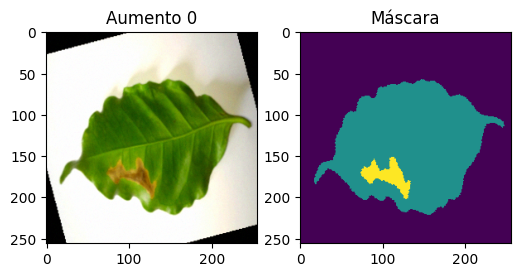

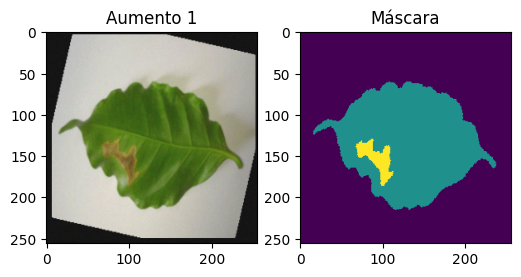

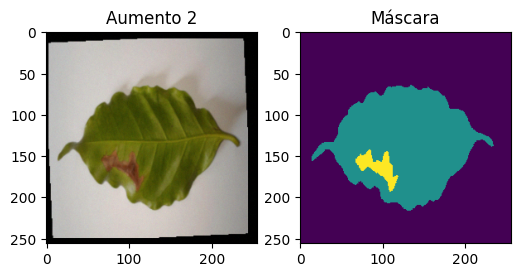

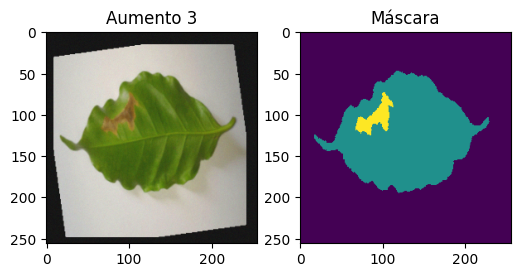

In [7]:
sample_img = Image.open("coffee_leaves/coffee_leaves/train/imgs/60.jpg").convert("RGB")
sample_mask = Image.open("coffee_leaves/coffee_leaves/train/masks/60_mask.png")

for i in range(4):
    img_t, mask_t = preprocess_training_sample(sample_img.copy(), sample_mask.copy())
    plt.figure(figsize=(6,3))
    plt.subplot(1,2,1); plt.imshow(img_t.permute(1,2,0).cpu().numpy()*IMG_STD.numpy()+IMG_MEAN.numpy()); plt.title(f"Aumento {i}")
    plt.subplot(1,2,2); plt.imshow(mask_t.cpu().numpy()); plt.title("Máscara"); plt.show()
